In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from gensim.models import Word2Vec
from bs4 import BeautifulSoup
from nltk import word_tokenize
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from gensim.models.ldamodel import LdaModel
from gensim import corpora
import pickle
from sklearn.externals import joblib
from nltk.corpus import wordnet as wn
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.corpora import Dictionary
from scipy.spatial import distance
from scipy.stats import entropy as KL
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 16)


C:\Users\Daria\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Daria\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Daria\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Загружаем модели

In [2]:
model_doc2vec= Doc2Vec.load("d2v-5.model")

In [3]:
gmm = joblib.load('gmm.joblib') 

In [4]:
corpus = pickle.load(open('corpus2000.pkl', 'rb'))
lda = LdaModel.load('model100.gensim')

In [5]:
dictionary = Dictionary.load('dictionary2000.gensim')

Функции для получения векторов из сообщений

Токенизация для doc2vec

In [6]:
def clean_text_from_html(text):
    return BeautifulSoup(text, "lxml").text

def text_to_tokens(text):
    cleaned = clean_text_from_html(str(text))
    tokens = word_tokenize(text)
    return [word for word in tokens if word.isalpha()]

Лемматизация для LDA

In [7]:
en_stop = set(nltk.corpus.stopwords.words('english'))

In [8]:
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma

In [9]:
def lemmatize(text):
    tokens = text_to_tokens(text)
    result = [get_lemma(token) for token in tokens if len(token)>2 and token not in en_stop]
    return result 

Получение векторов

In [10]:
def get_vector_clusters(message):
    tokens = text_to_tokens(message)
    vector_d2v = model_doc2vec.infer_vector(tokens, 0.05)
    return gmm.predict_proba([vector_d2v])[0]

In [11]:
def get_vector_lda(message):
    themes = lda.get_document_topics(dictionary.doc2bow(lemmatize(message)))
    vector = np.zeros((20,))
    for theme in themes:
        vector[theme[0]] = theme[1]
    return vector

Читаем цепочки сообщений:

In [12]:
threads = []
with open('raw_threads.txt') as f:
    current_thread = []
    for line in f:
        message = line.strip()
        if (len(message) == 0):
            continue
        if (message[0] == "#"):
            if (current_thread):
                threads.append(current_thread)
            current_thread = []
        else:
            current_thread.append(message)
    if (current_thread):
        threads.append(current_thread)

In [13]:
len(threads)

18

Переведём сооббщения в векторный вид

In [14]:
threads_clusters = [np.array([get_vector_clusters(message) for message in thread]) for thread in threads]

In [15]:
threads_lda = [np.array([get_vector_lda(message) for message in thread]) for thread in threads]

Расссотрим различные меры расстояния

In [16]:
def plot_distance_for_thread(thread, title):
    dist_euclidian = []
    dist_cosine = []
    dist_chebyshev = []
    dist_braycurtis = []
    dist_minkowski = []
    a = thread[0]
    for message in thread[1:]:
        b = message
        dist_euclidian.append(distance.euclidean(b, a))
        dist_cosine.append(distance.cosine(b, a))
        dist_chebyshev.append(distance.chebyshev(b, a))
        dist_braycurtis.append(distance.braycurtis(b, a))
        dist_minkowski.append(distance.minkowski(b, a, 3))
        a = b
    fig = plt.figure(figsize = (10, 6))
    ax = fig.add_subplot(111)
    for dist in [(dist_euclidian, "Euclidian"), 
                 (dist_cosine, "Cosine"), 
                 (dist_chebyshev, "Chebyshev"), 
                (dist_braycurtis, "Braycurtis"),
                (dist_minkowski, "Minkowski")]:
        ax.plot(range(1, len(dist[0])+ 1), dist[0], label = dist[1])
    plt.title(title)
    legend = ax.legend(loc='best', shadow=True, fontsize='x-large')
    plt.show()

In [17]:
def print_thread(thread):
    for i, message in enumerate (thread, 0):
        print(i, message)

0 Good Morning Darling, Do you know when the UBS paydays are? We are just trying to figure out what to expect. Also, I need a copy of my signed agreement with UBS, the loan folks for my new condo want it. If you will fax it to me, but call me first so I can wait by the fax for it, I would be grateful. Thanks, Cara Freeland! ;)
1 Good morning Cara! Hope that you had a good weekend - when do you move into the new condo? 1. UBS payrolls are the same as Enron (isn't that nice - no change there)! 2. Julie Kearney should have a copy (I know she was keeping copies in case something happened to the fed ex packages). Let me know if she doesn't have for some reason. Have a great day! Amy
2 I have asked her a couple of times, so if you have one that would be better.
3 We don't have them here, but I will call Stamford and see what I can do. Thanks! Amy
4 no worries,. I e-mailed julie again Just hold off for now. I need to get my loan approved and my bonus in hand before I can move in, I am anxious

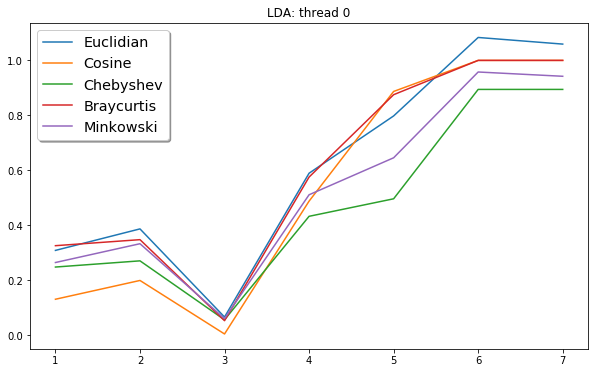

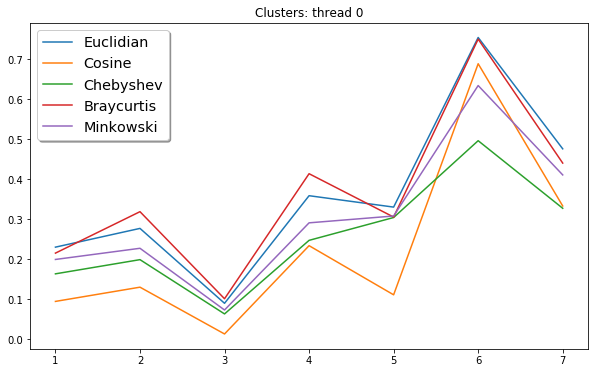

0 I will be getting in town at 7pm on Friday the 22nd. I would love to go to dinner, so if you make reservations for that night I can probably make it around 8pm. If everyone else can't do it on the 22nd, then I hope to see you all sometime before I head back to California.
1 Hi Girls! It's that time again. We need to get everyone together for our annual Christmas Dinner. I have spoken to many of you and tried to come up with a good time for everyone. Unfortunately, there doesn't seem to be a "perfect day", but how about Friday-Dec. 22nd? Please respond and tell me what you think. I have had a few suggestions for a place-Churrasco's, America's, Ruggles, Benji's, Sullivans-please send a suggestion. Don't say it doesn't matter because majority vote will win and there will be no recount. The time will probably be around 8 p.m. I know the 22nd is close to Christmas, so the 19th has also been suggested-but I am afraid not everyone will be in town yet. Please send me your thoughts on the day

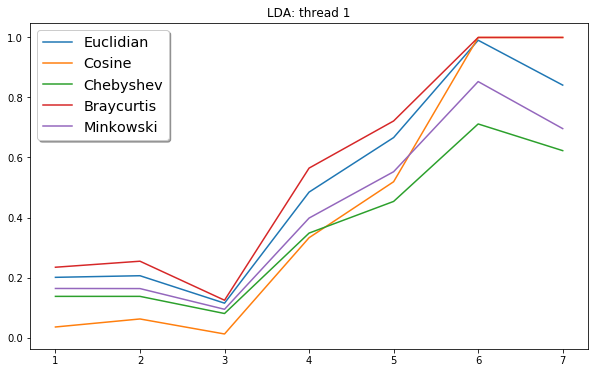

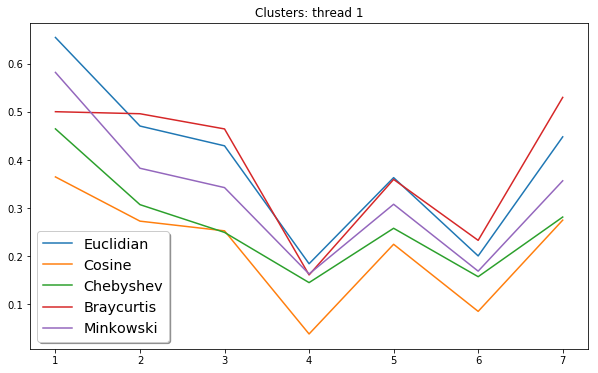

0 Hello Kay--- I need some free legal advice and you are my favorite attorney. I'll buy you a drink as payment in kind. Try and remember El Paso work in Arizona. Arizona has statue that says you must make a twenty day preliminary notice to file a lien. If you don't file such notice you waive your right to ever file a lien. I remember this from our previous work out there. We have a vendor who is supplying services to one of our subcontractors. He has sent us a twenty day notice to file a lien. There is no dispute but he is sending the notice anyway. I understand all of that. My question is this----it asks for us (BE&K) to sign and acknowledge receipt of the notice. It doesn't exactly read like I am required to acknowledge receipt. What do you think or remember? Am I required to sign the notice or not. Minor point I know, but I'd rather not raise the flag in Birmingham. Thanks. I really just want to hear from you and this is all I could come up with for an excuse to write. Gerry Turner


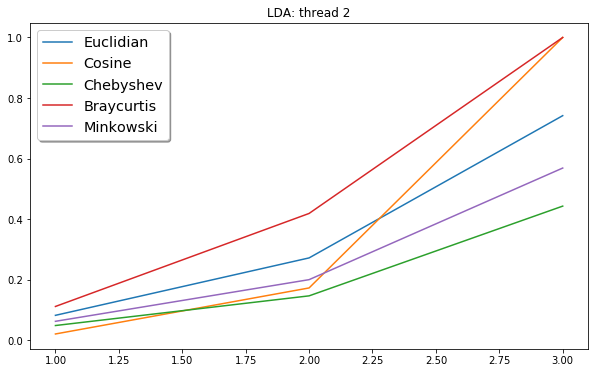

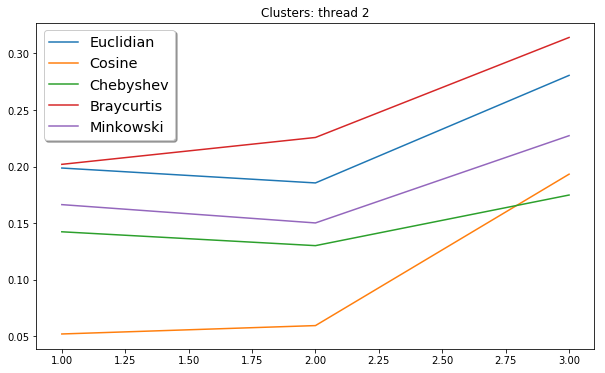

0 Rick: Please find attached an EIM report on our prospective counterparty(ies) on the Balli-Klockner $40m steel prepay. We received this report from EIM after informing them that we would require a background check by Lynn's team before proceeding. Apparently, Enron closed a deal in the US earlier this year with WeBco which is a joint venture between Balli Group and Wierton Steel. The commercial team is arguing that RAC and others must have investigated the allegations below at the time, but obviously felt comfortable enough to let the deal proceed. I believe that Ted is planning to give you a call on this to discuss. Regards. Olivier PS: I am forwarding you another email we received from EIM on the same subject.
1 fyi, any thoughts? rick
2 I do not believe the Alaghband issue was researched for the first deal; however, the two deals are vastly different from each other. The first deal (with Webco JV) was a 1 year inventory management deal in which we had title to the product the enti

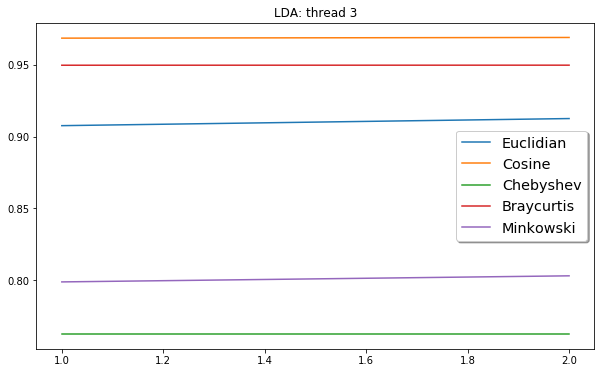

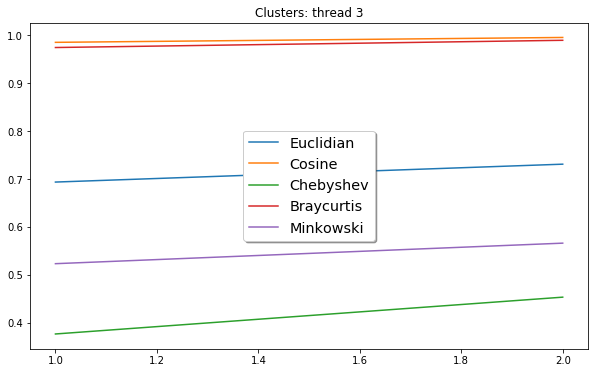

0 All materials have been received, however the documents is being reviewed by Legal prior to distribution, which is targeted for Monday. Thank you. sent by: Laura Valencia Executive Assistant Tel: 713-853-6485 Fax: 713/853-2534 CONFIDENTIALITY NOTICE The information contained in this email may be confidential and/or privileged. This email is intended to be reviewed by the individual or organization named above. If you are not the indented recipient, you are hereby notified that any review, dissemination or copying of this email or its attachments, if any, or the information contained herein is prohibited. If you receive this email in error, please immediately notify the sender by return email and delete this email from your system. Thank you.
1 We will need to reschedule the Corporate Governance meeting. I will be in touch. Thank you, Laura Valencia Laura Valencia Executive Assistant Tel: 713-853-6485 Fax: 713/853-2534 CONFIDENTIALITY NOTICE The information contained in this email may

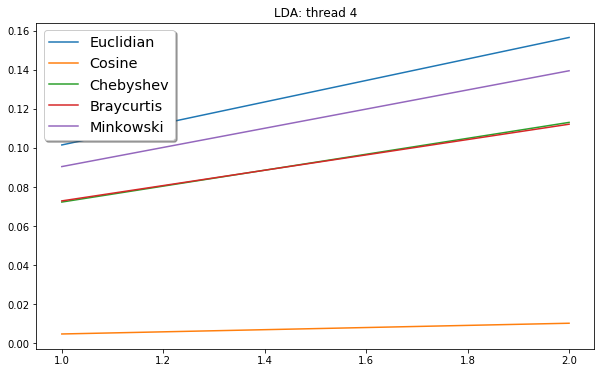

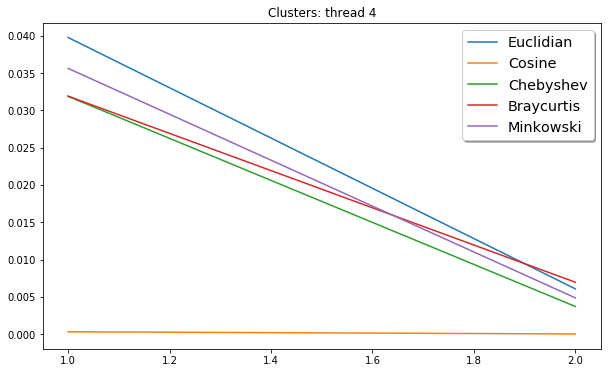

0 Liz: Put me down for $50. Mark
1 Is it per game or point or what?
2 I'm bowling to help "strike out" ALS (Lou Gehrig's disease). If you have not sponsored someone else, I would very much like for you to sponsor me. The event takes place on July 29. I will need all donations by July 26. Any donation is greatly appreciated and matched by Enron. Many Thanks, Liz
3 just come by - I'll contribute.
4 I think you're cheating trying to get a fixed amount.... I'll give $1 per pin. Good luck, John Liz
5 Fifty dollars.


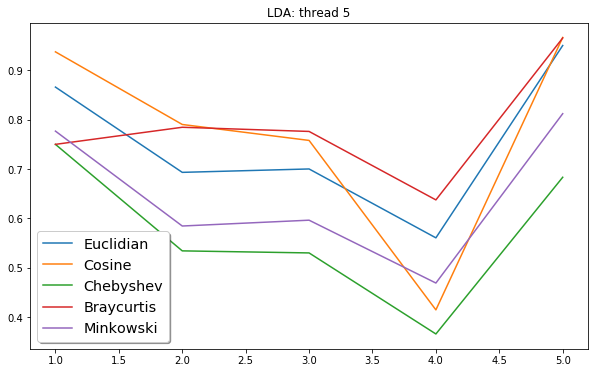

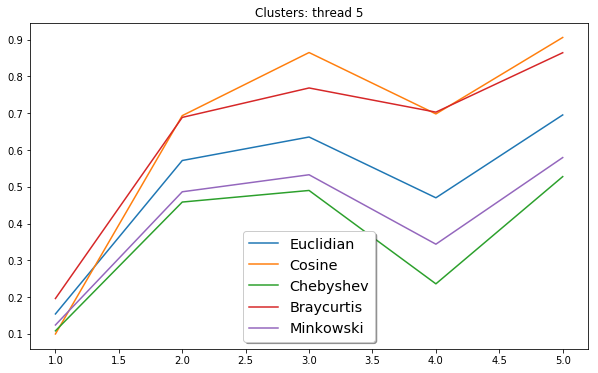

0 What's the correct delivery point on this deal - sell PGE, mar-01 through dec-01, on peak, 50 mw, DJ Mid-C index (trade date 2/12)? Kate -----------------
1 I've forwarded this onto Diana - she's out to lunch right now. I'll let you know when I hear what the correct delivery point is. Kate From: Kimberly Allen on 03/06/2001 01:19 PM CST To: Kate Symes/PDX/ECT@ECT cc: Subject: #519874.01 Kate, This trade was changed on Feb. 20 from COB to Portland General as the delivery point. Could you check with Diana about this trade. Portland General is saying it is COB. KI Enron Power Marketing, Inc. Kimberly Indelicato Office:713-853-3031 Trading Support Fax:713-646-2443 kallen3@enron.com
2 Kate, This trade was changed on Feb. 20 from COB to Portland General as the delivery point. Could you check with Diana about this trade. Portland General is saying it is COB. KI
3 The delivery point on this deal originally was confirmed as COB S/N. Due to complications in the P& L calculation, Sean changed t

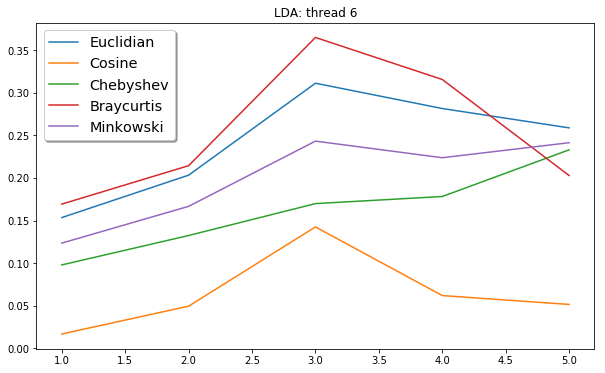

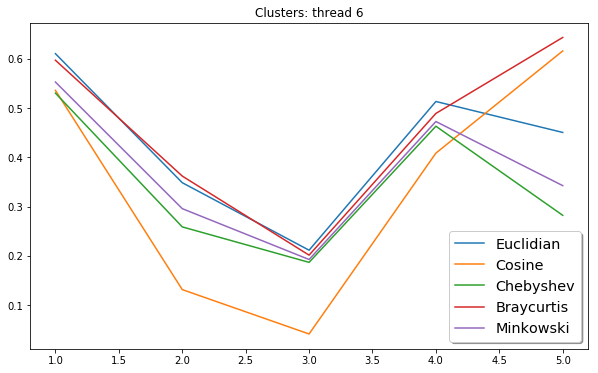

0 Deal should be no confirm. It was done by Stan Cocke in Services, and those guys deal directly with their counterparty contacts. He thought he marked this no confirm, but must have defaulted to confirm anyway. I'll change deal as soon as risk is done with their calc.
1 This deal does not have a contact. Thanks!
2 Thanks for the reminder - deal is changed and note is in comments section.
3 When you change this to no confirm, please put a note in the comment section about why we are not domfirming it, because it falls within our guidelines to confirm and at somepoint, I will be asked why we did not confirm this deal. Thanks!
4 Deal should be no confirm. It was done by Stan Cocke in Services, and those guys deal directly with their counterparty contacts. He thought he marked this no confirm, but must have defaulted to confirm anyway. I'll change deal as soon as risk is done with their calc.
5 This deal does not have a contact. Thanks!
6 I just forwarded this e-mail to Stan and then spok

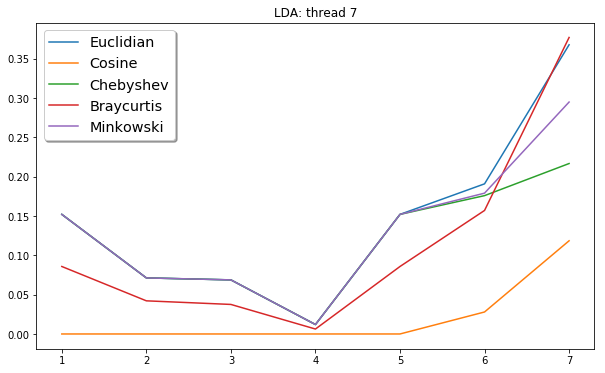

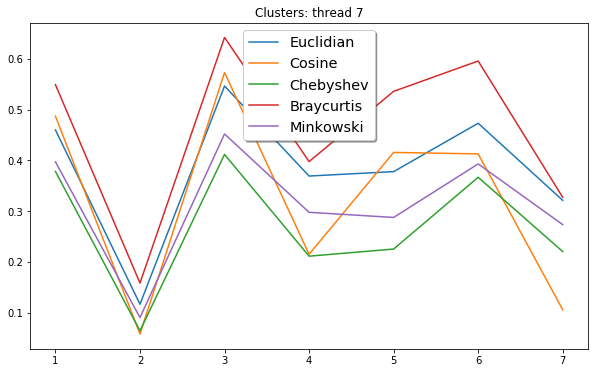

0 Daren, On the above mentioned dates, there was no nomination at the Enerfin meter. 6/3/99 and 6/8/99 revealed activity for ENA (202K). Can the deal be extended for 6/4 (548 dec.) and 6/9 (40 dec.) to cover this flow so that Volume Management can create an accounting arrangement for these two days? Thanks -Jackie- 3-9497
1 Jackie, Please get with the East Desk on this. If they agree, we can roll the deal.
2 Is this date really June of 1999? Hopefully we're not just finding out about this? I don't think we can even process this request. The East Desk was not up and running on Unify in June of 1999. All of our pathing for June of 1999 was in Autonoms and it's not y2K compatabile. With the volumes involved being so small and the accuracy of the data at Enerfin in question, why don't we let this volume hit the new OBA at Enerfin as a PPA??? I welcome your thoughts.
3 Enerfin TETCO Victor, Can we go this far back? Please advise. Cindy -----------------
4 I'm assuming from your answer that 

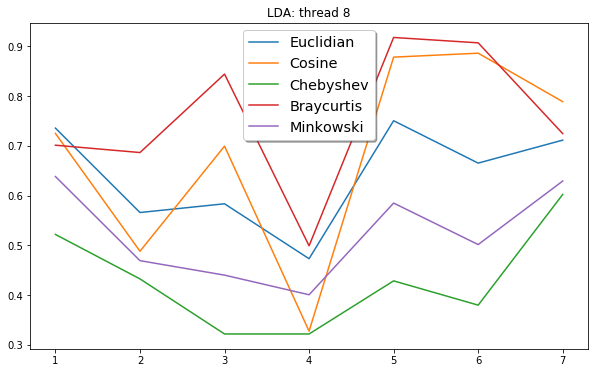

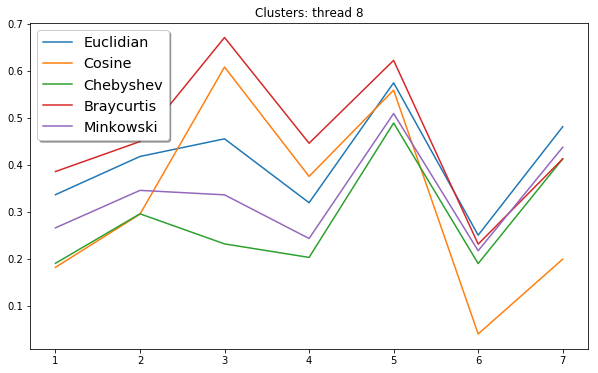

0 Daren, Can you please "0" all activity on Sitara Deal Tickets 113858, 93779, 138094, 120866, 138544, 139661 (relative to 98-3405)? This activity is now being nomed @ 98-9643. I think that I've referenced all of the deal tickets @ this meter. Thanks -Jackie- 3-9497
1 Jackie and Stella, I need ya'll to get together and work out how to handle this at Stratton. I know that we get the estimated volume from Exxon daily and I would think that this volume will need to be allocated among the different deals. But, Exxon will not have them broken out.
2 Daren, Wanted to let you know that there are still two sitara deals that need to have the expected volume brought down to "0" of the list that I previously sent you. They are 114099 and 92918. I appreciate you revising the ones that you have and you probably were going to handle the above two today. In case you were please disregard this notice. If you had fogotten, this can serve as reminder. As usual, thanks for your help. -Jackie- 3-9497
3 do

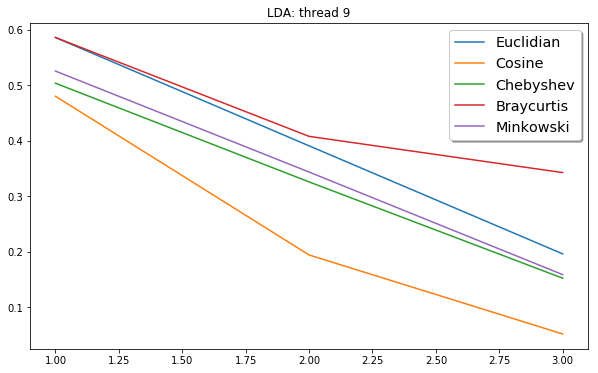

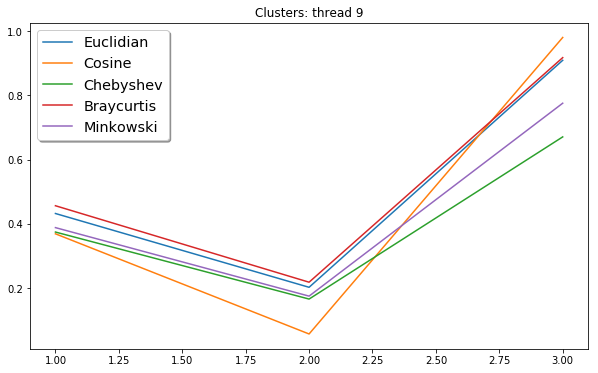

0 Thought you would like to see the "cool" yours truly with Quiet Riot. I am thinking about joining the band... ?
1 You are so cool. I can't believe that the person in that picture with the biggest rock band of all time, was in my bed last night. Wow! Everyday I found something out that just makes me want you more and more! Ha Ha Ha How is Ms. Barbara doing today? I am weary from the pile of other people's projects couched on top of my head but "I will survive, Hey Hey". I've lost the edge Maverick, I am holding on too tight!
2 In case you are not on your work email.
3 Rock and Roll!!!!!!!
4 So she's already thinking about moonlighting with another band? We need to call a band meeting STAT! Eric Gillaspie 713-345-7667 Enron Building 3886
5 I forwarded your picture to Eric and your little comment about you wanting to join Quiet Riot has sent shockwaves through the members of Monkey Pump. First of all, you haven't even been voted into the band yet (seems the chances are getting less like

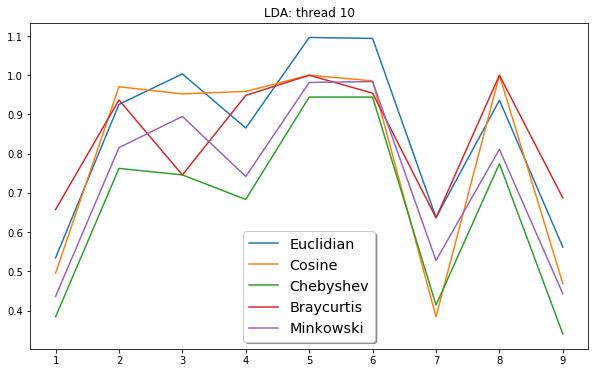

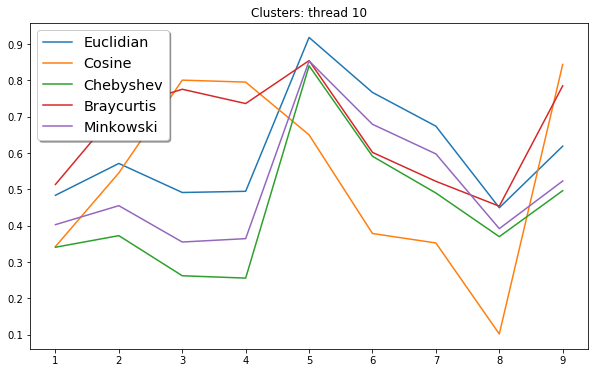

0 I found this picture of my boat on the internet!
1 You know, I must have received your message on Tuesday because I remember reading it - but I can't find it in my computer. Can you resend so I'll have the dates? My guess is you shouldn't arrange space for me. If I can get there for part of the time and there is a spare couch then fine & if not I'm sure I'll find a room somewhere close by. -----------------
2 What's the length of your boat? Does it have a cover? D
3 I believe the boat is 18 to 19 ft long and I do have a boat cover. I will bring the boat information with me tomorrow for anymore questions. I recently took it to the shop to get it ready for this season and the salesman said it looked brand new. It has a brand new battery and everything runs perfectly. Call me if you want to take a look at it. Briant 66459
4 I checked the boat and it is 17 ft, 7 in. long, it is a Capri model # 1750CH, it has a am/fm cass. The motor is 3.0L MerCruiser Alpha Sterndrive (135 hp)
5 Briant, I

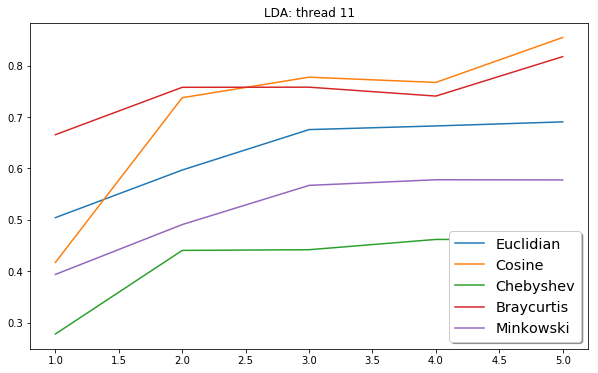

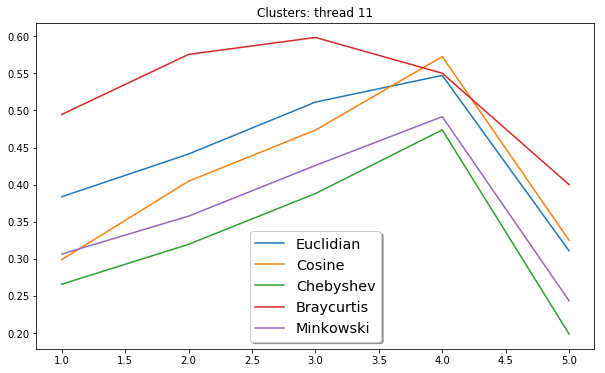

0 FYI.
1 I have sent the message again to make curves as accurate as possible through 2015. We are doing are best. The Entergy situation was simply a back office mistake. The NY off-peak is a work in progress and will get better every day. The legs never trade, only the cals, therefore, we have to use common sense for month values. Thanks for the info. In most cases, Narsima is exactly right.
2 I think it is appropriate to instruct Risk to put the charges associated with the PJM scalar in the Change Deal Bucket as this was out of the Retail Commodity Group's control. I am trying to hold these guys accountable for positions, p/l and such and I think this is the only way to fairly account for results that they could affect vs. someone else's error/mismark. Let me know if you think this is appropriate.
3 I agree with this approach and I'm fine with this allocation. My objective is to get everything as accurate as possible so the proper price signal is being sent to retail and wholesale or

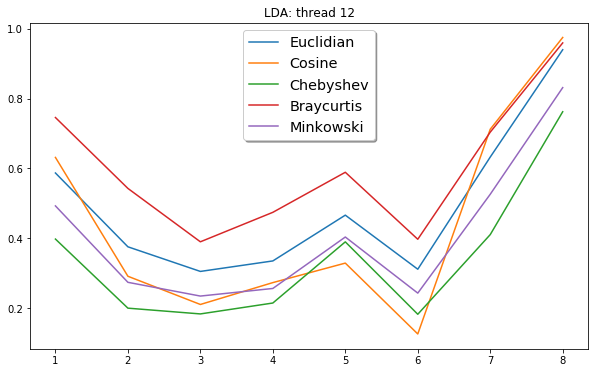

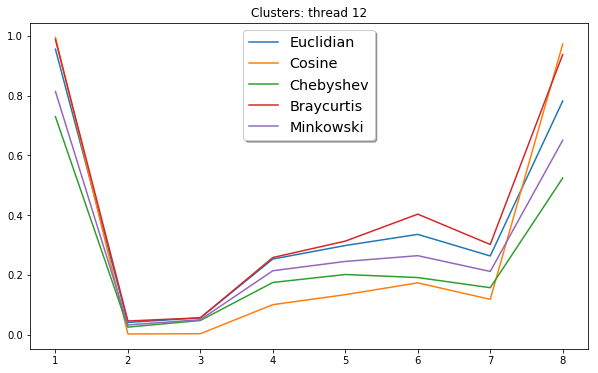

0 Daren, I am trying to get some payments out to Williams for old months 11/2000 and 1/2001 but global counterparty said this deal should have Black Marlin Pipeline Company Inc. instead of Black Marlin Pipeline Company effective 3/99. The Black Marlin Pipeline Company was for an internal record (when it was an Enron entity).
1 This ticket starts with 7/99 production. How were all of the other months paid? D
2 Prior to 7/99 this was ENA not HPL, but there may be some issues on it as well for 3/99 to 6/99. The deal ticket we used was 62717. I will have to look further into the ENA activity because I know we still have some invoices that were paid under one company and we still have drafts under the other.
3 Daren, Will you let me know when this change has been made? I need to get some payments finaled by 3pm tomorrow.
4 Anthony, Can you change the counterparty name on deal 93836 to Black Marlin Pipeline Company Inc.? D
5 Daren, Have you had a chance to look at this yet?
6 Anthony, Can yo

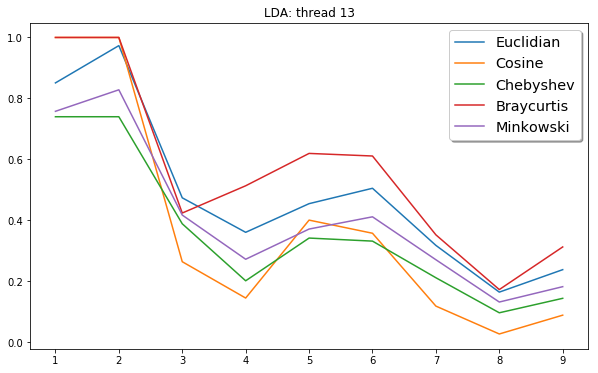

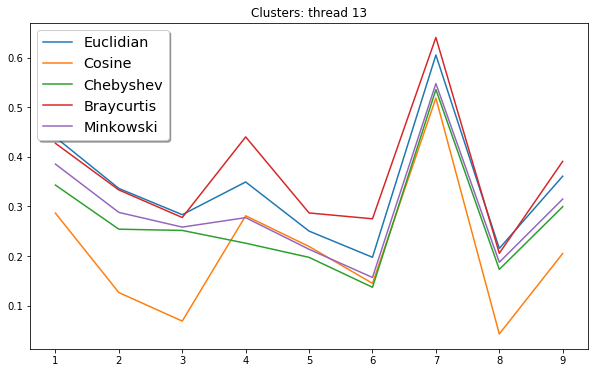

0 Elizabeth, Yes I would like to discuss this with you. My schedule for Wednesday afternoon or Thursday looks good. How about you? Kim.
1 Sorry for the delay in response...I'm up to my ears in preparation for TW's new contracts/capacity release implementation. I am available both Wednesday and Thursday afternoon. Please let me know which is better for you. Thanks, Elizabeth
2 How about today (Thursday) at 2:00. Can you come to EB1336?. John, are you available, also? Thanks, Kim.
3 Can we move it back to 3pm...someone just scheduled another meeting for our upcoming implementation.
4 I have a conference call then. How about Friday morning or afternoon?
5 can we shoot for Friday at 9am?
6 Friday at 9:00am works for me. Where? Kim.


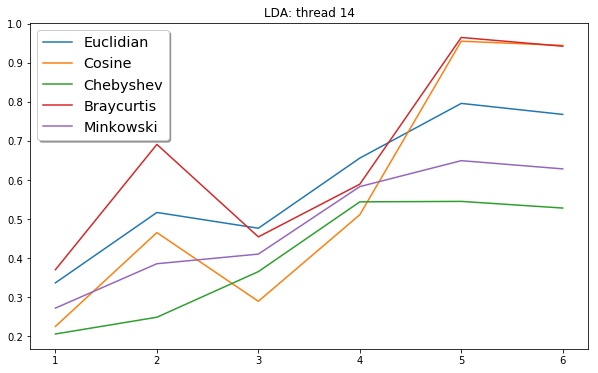

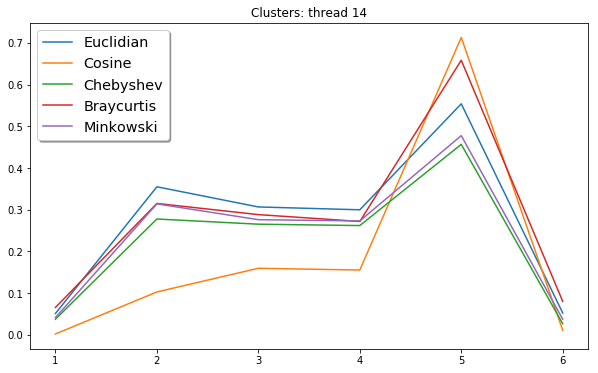

0 Dear Joe, Would it be possible for you to come in one day next week at about 3:00 p.m. to go over your discovery responses? Alternatively, you could come in two days at 4:00 p.m. On Thursday, I leave early for my son's soccer practice. Perhaps Tuesday and Friday would be good for you??? Jonda L. Stowell Legal Assistant The Fullenweider Firm 4265 San Felipe, Suite 1400 Houston, TX 77027 (713) 624-4100 Telephone (713) 624-4141 Facsimile e-mail: jls@fullenweider.com
1 Good Morning Jonda, I would like to met with Mr. Fullenweider today if that is possible? I'm going out of town Thursday thru Sunday of this week. I think it is very important that I speak with him as soon as possible. Please let me know if today is good for him. Thanks again, -Joe
2 Dear Joe, I'm sorry but I have Mr. Fullenweider scheduled in back-to-back meetings, hearings and depositions this week. I might be able to arrange a short telephone conference today or tomorrow. Otherwise, his deposition schedule may clear up o

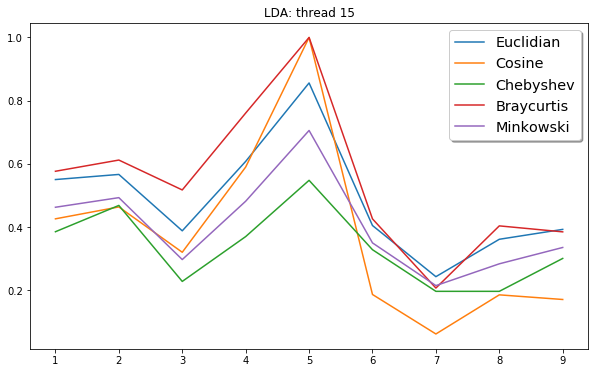

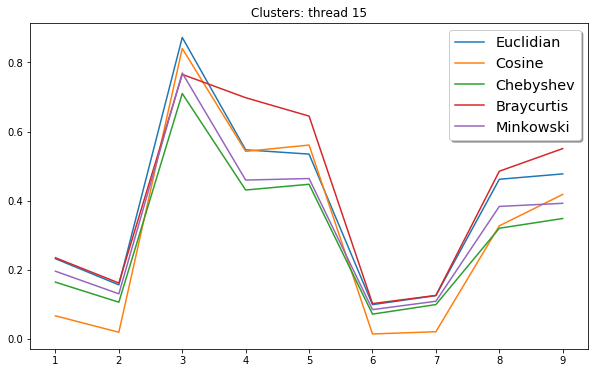

0 Dutch - please send me the numbers. Sarah
1 Sarah , What I was remembering was the front months exposures we had at EDF MAN. Prior to moves After DEC -2,003 1,967 JAN 10,502 -1,588 FEB 1,338 552 MAR -7,013 188 APR 5,831 33 the over all position before the move was 1,240 and as of yesterday it is 4,205. Let me know what the concerns are at EDF MAN and the request that they are making. We can shift some positions around if the have levels by months that they want us to stay under. Dutch
2 EDF is concerned because they are worried about the number of positions they are taking on for Enron. They want to make an additional margin call of $45 million which ENE is not willing to post (true reason: corporate liquidity issues.) According to our broker agreement with EDF, EDF is not allowed to request more margin than the NYMEX requires so we refused on that basis. EDF may want to reduce the positions they are holding based on their perceived risk of ENE. Ira Polk, the CFO of EDF Man said the 

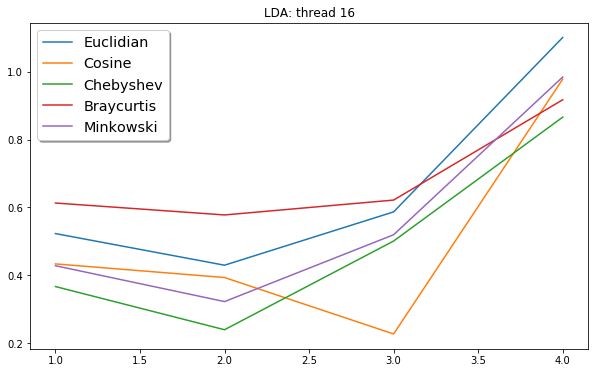

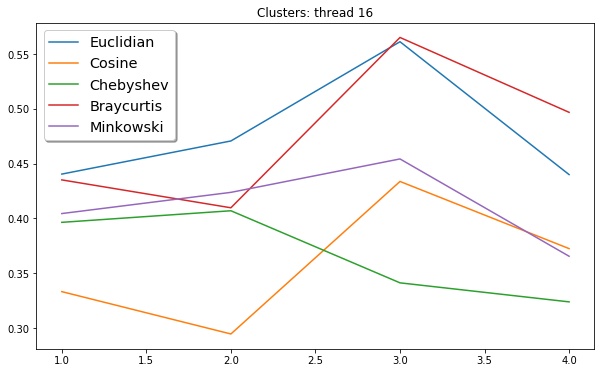

0 Gail: Attached is a form of ECI unanimous consent. Will you accept fhis for the purpose of signing a repo agreement and transacting thereunder? Please let me know. Also, you can email repo documents to me. Thanks. Sara Shackleton Enron North America Corp.
1 Gail: The commercial team is pressuring for a fairly quick implementation of a repo agreement. If the consent which I sent yesterday is not satisfactory, please advise as soon as possible so that I can obtain a repo specific consent. Also, could you please submit repo documents to me for review. I do not know who may have contacted you from the London group (Enron Credit Ltd.) but we can surely coordinate. That entity should have its own form of unanimous consent or resolution. Thanks for your help. Sara Shackleton Enron North America Corp.
2 Sara - I will look at your consent document today. Attached please find the standard repo documentation used by Goldman. Gail
3 Gail: Is the attached Master Repurchase Agreement used by both 

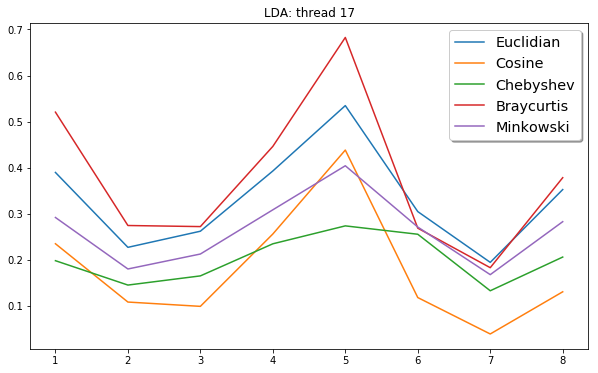

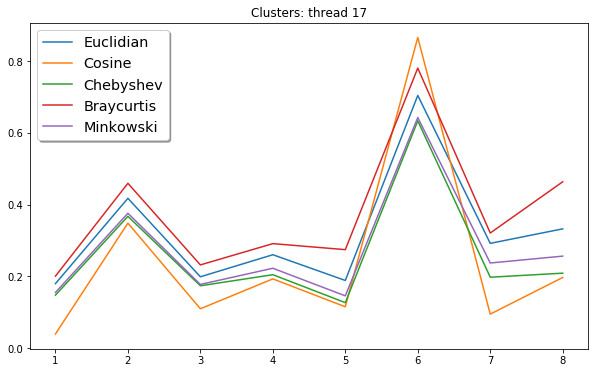

In [18]:
for i in range(len(threads)):
    print_thread(threads[i])
    plot_distance_for_thread(threads_lda[i], "LDA: thread "+ str(i))
    plot_distance_for_thread(threads_clusters[i], "Clusters: thread "+ str(i))